# Image Classification with TensorFlow

In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [ ]:
# Downloading the data

In [3]:
# We will be using the CIFAR-10 data set. 
# It consists of 60,000 images, each  32×3232×32  color pixels, each belonging to one of ten classes. 
# The following cell will download the data, in NumPy's .npy format.
!aws s3 sync s3://dataincubator-course/cifar10/ .

In [4]:
# Loading the data
import numpy as np

train_images = np.load(open('train_images.npy', 'rb'))
train_labels = np.load(open('train_labels.npy', 'rb'))
validation_images = np.load(open('validation_images.npy', 'rb'))

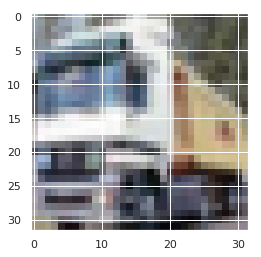

In [5]:
# The images are stored as four-dimensional arrays. 
# The first index indicates the image number, the second and third the  xx  and  yy  positions, and the fourth index the color channel. 
# Each pixel color is a floating point number between 0 and 1. 
# This convention allows us to view the images with matplotlib:

matplotlib.pyplot.imshow(train_images[1])

In [6]:
train_labels[0]

6

In [7]:
# Class Names
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
# TensorFlow resets
# The cell below includes the reset code

import tensorflow as tf

sess = None

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

def reset_vars():
    sess.run(tf.global_variables_initializer())
    
reset_tf()

In [9]:
# Building a graph that takes in a series of images, as well as a base image, 
#and returns the average over all pixels between the base image and each image in the series. 

images = tf.placeholder(dtype=tf.float64, shape=(None, 32, 32, 3))
base = tf.placeholder(dtype=tf.float64, shape=(32, 32, 3))

def delta_func(images, base):
    
    #Getting the Red values
       #R1 = base[:,:,0]
       #R2 = images[:,:,:,[0]]
       #R_delt = (R1 - R2)
    R_delt2 = tf.square(tf.subtract(base[:,:,0], images[:,:,:,0]))
    #Getting the Greens
       #G1 = base[:,:,1]
       #G2 = images[:,:,:,[1]]
       #G_delt = (G1 - G2)    
    G_delt2 = tf.square(tf.subtract(base[:,:,1], images[:,:,:,1]))
    #Getting the Blues
       #B1 = base[:,:,2]
       #B2 = images[:,:,:,[2]]
       #B_delt = (B1 - B2)    
    B_delt2 = tf.square(tf.subtract(base[:,:,2], images[:,:,:,2]))
    #Getting Hue Inference 
    #Red differences
       #R_bar = (R1+R2)/2
    R_bar = tf.multiply(tf.add(base[:,:,0], images[:,:,:,0]), 0.5)
    Hue = R_bar*(tf.subtract(R_delt2, B_delt2))
    
    #The full equation
    C_delta = tf.sqrt(tf.add_n([(tf.multiply(R_delt2, 2)), tf.multiply(G_delt2, 4), tf.multiply(B_delt2, 3), Hue]))
    C_deltamean = tf.reduce_mean(C_delta, axis=(1, 2))
    
    return C_deltamean

In [10]:
#Turn function into an object
comparison = delta_func(images, base)

In [11]:
# computing the difference between the first validation image and all of the training images
#Actually run that object
q1values = sess.run(comparison, feed_dict = {images: train_images, base: validation_images[0]})

In [12]:
# finding the 100 closest images from the training set to this image
#get the indices of those values
ind = np.unravel_index(np.argsort(q1values, axis=None), q1values.shape)
q1ans = ind[0][:100]

### Smallest delta model

In [ ]:
##THE ACTUAL MODEL
#Creating the placeholder for photos
from tqdm import tqdm_notebook
typical_photos_vars = []
#need to make a loop to make all of our default photos:
for i in tqdm_notebook(range(10)):
    typical_photos_vars.append(tf.Variable(np.random.normal(0.5,0.1, size=(32,32,3))))

#need to initialize them      
reset_vars()

In [19]:
#let's train them all on the appropriate data
step = 1

for i in range(10):
    temp_photos = train_images[np.where (train_labels == i)]
    loss = tf.reduce_mean(delta_func(images, typical_photos_vars[i]), name="typical_loss")    
    train = tf.train.GradientDescentOptimizer(step).minimize(loss)
    for j in range(200):
        sess.run(train, feed_dict={images: temp_photos})
        if j%50==0:
            print(sess.run(loss, feed_dict={images: temp_photos}))
    print('one picture down: ', i)

0.7413981375513399
0.7124452126552158
0.6911659023469697
0.6758625697668492
one picture down:  0
0.7719089287049299
0.744679717342086
0.7246937705362688
0.7103834236398843
one picture down:  1
0.6774103658542789
0.6470716022053703
0.6255708911437279
0.6108971690632458
one picture down:  2
0.7430277438441313
0.7161591563879609
0.6967319266080494
0.6831352022117366
one picture down:  3
0.6521260140576501
0.61477321328802
0.5878335662614453
0.569156609199383
one picture down:  4
0.7293428746672583
0.699952145033025
0.6786614043696767
0.663752856472111
one picture down:  5
0.6972313942623852
0.6560866587289826
0.6253458028461487
0.603227956701938
one picture down:  6
0.7182251481549098
0.6883619638940145
0.6667731736639958
0.6517138632250511
one picture down:  7
0.7137572143304869
0.6790254206053076
0.6534569587836259
0.6351391861020318
one picture down:  8
0.7724858509588471
0.739325288954258
0.7142652918809241
0.695719339240552
one picture down:  9


In [23]:
#get actual typical photos
typical_photos = np.array([sess.run(x) for x in typical_photos_vars])

In [24]:
#Let's make some predictions!
#find the lowest difference
diff_array = sess.run(comparison, feed_dict={images: typical_photos, base: validation_images[0]})
print(diff_array)
predicted_index = np.argmin(diff_array)
print(predicted_index)

[1.04430923 1.03323473 1.01417959 0.99857119 0.99920316 0.97604668
 1.00506489 1.02422183 1.03405031 1.07633495]
5


In [ ]:
#Let's make a list of predictions
q2ans = []
for i in tqdm_notebook(validation_images):
    diff_array = sess.run(comparison, feed_dict={images: typical_photos, base: i})
    q2ans.append(np.argmin(diff_array))
    
#Those predictions are floats, rather than integers. Let's change that. 
q2ans = [int(x) for x in q2ans]

### Softmax model

In [ ]:
#converting integers to one-hot encoding of labels
all_photo_dist = []

for i in tqdm_notebook(train_images):
    diff_array = sess.run(comparison, feed_dict={images: typical_photos, base: i})
    all_photo_dist.append(diff_array)

In [30]:
#Setting up my model
x_soft = tf.placeholder(tf.float32, [None, 10], name="pixels") #every photo in training images
y_labels_soft = tf.placeholder(tf.int64, [None,], name="labels")

W_soft = tf.Variable(tf.zeros([10, 10]), name="weights")
b_soft = tf.Variable(tf.zeros([10]), name="biases")
y_soft = tf.matmul(x_soft, W_soft) + b_soft

y_labels_one = tf.one_hot(y_labels_soft, 10)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_soft, 
                                                              labels=y_labels_one))
train = tf.train.GradientDescentOptimizer(1).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_soft, 1),
                                           y_labels_soft),
                                  tf.float32))

In [ ]:
#initailizing the variables
reset_vars()
#training the model
for i in tqdm_notebook(range(5000)):
    sess.run(train,
             feed_dict={x_soft: all_photo_dist, 
                        y_labels_soft: train_labels})        
    if i % 100 == 0:
        print(sess.run([loss, accuracy],
                       feed_dict={x_soft: all_photo_dist, 
                                  y_labels_soft: train_labels}))

In [ ]:
#Getting predictions
pred = []
for i in tqdm_notebook(validation_images):
    dist_output = sess.run(comparison, feed_dict={images: typical_photos, base:i})
    dist_output = dist_output.reshape(1,10)
    score = sess.run(y_soft, feed_dict={x_soft: dist_output})
    pred.append(np.argmax(score))

#Those predictions are floats, rather than integers. Let's change that. 
q3ans = np.array(pred)

### Fully-connected model

In [35]:
import numpy as np
from tqdm import tqdm_notebook
from tensorflow import keras
from tensorflow.keras.utils import to_categorical as one_hot
from sklearn.model_selection import train_test_split
from scipy import ndimage, misc
import os

In [36]:
train_images = np.load(open('train_images.npy', 'rb'))
from sklearn.model_selection import train_test_split

#test train split
x_train, x_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.4)
for i in x_train, y_train, x_test, y_test:
    print(len(i))
    
y_train = one_hot(y_train)
y_test = one_hot(y_test)

30000
30000
20000
20000


In [37]:
hidden_size=64
N_PIXELS= 32 * 32
N_CLASSES = 10

In [38]:
x_fc = keras.layers.Input(shape=(32,32,3))
flat_x = keras.layers.Flatten()(x_fc)

hidden = keras.layers.Dense(hidden_size,
                            activation='sigmoid',
                            kernel_initializer=keras.initializers.TruncatedNormal(stddev=N_PIXELS**-0.5)
                           )(flat_x)

y_fc = keras.layers.Dense(10,
                       activation='softmax',
                       kernel_initializer=keras.initializers.TruncatedNormal(stddev=hidden_size**-0.5)
                      )(hidden)

model = keras.models.Model(inputs=x_fc, outputs=y_fc)

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.5),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=8,
                    batch_size=50,
                    validation_data=(x_test, y_test))


Train on 30000 samples, validate on 20000 samples
Epoch 1/8
30000/30000 [==============================] - 4s 123us/step - loss: 1.9772 - acc: 0.2776 - val_loss: 1.8530 - val_acc: 0.3319
Epoch 2/8
30000/30000 [==============================] - 3s 108us/step - loss: 1.8019 - acc: 0.3504 - val_loss: 1.8253 - val_acc: 0.3490
Epoch 3/8
30000/30000 [==============================] - 3s 109us/step - loss: 1.7486 - acc: 0.3674 - val_loss: 1.7257 - val_acc: 0.3842
Epoch 4/8
30000/30000 [==============================] - 3s 113us/step - loss: 1.7003 - acc: 0.3904 - val_loss: 1.7867 - val_acc: 0.3600
Epoch 5/8
30000/30000 [==============================] - 3s 113us/step - loss: 1.6705 - acc: 0.4048 - val_loss: 1.6631 - val_acc: 0.4120
Epoch 6/8
30000/30000 [==============================] - 3s 112us/step - loss: 1.6490 - acc: 0.4105 - val_loss: 1.6827 - val_acc: 0.3960
Epoch 7/8
30000/30000 [==============================] - 3s 114us/step - loss: 1.6339 - acc: 0.4151 - val_loss: 1.7261 - val_acc

In [44]:
predictions_fc = model.predict(x_test[:3])
print("Raw Predictions:\n")
print(predictions_fc,"\n")
print("Rounded Probabilities:\n")
print(np.round(predictions_fc,3),"\n")
print("Predicted Labels:\n")
print(np.argmax(predictions_fc, axis=1))

Raw Predictions:

[[0.04203625 0.04106446 0.0079807  0.00867815 0.02276516 0.00374457
  0.00765683 0.01244915 0.6867311  0.16689363]
 [0.0267219  0.03262338 0.02091329 0.01386996 0.05313539 0.0378615
  0.12991683 0.5840951  0.06439523 0.03646735]
 [0.01059302 0.05630296 0.02525851 0.0650995  0.08640368 0.18071583
  0.07205153 0.03221193 0.4137793  0.05758373]] 

Rounded Probabilities:

[[0.042 0.041 0.008 0.009 0.023 0.004 0.008 0.012 0.687 0.167]
 [0.027 0.033 0.021 0.014 0.053 0.038 0.13  0.584 0.064 0.036]
 [0.011 0.056 0.025 0.065 0.086 0.181 0.072 0.032 0.414 0.058]] 

Predicted Labels:

[8 7 8]


In [45]:
ans_fc = model.predict(validation_images)

In [46]:
ans_fc2 = [int(np.argmax(x)) for x in ans_fc]
ans_fc2[:5]


[5, 8, 4, 9, 2]

### Convolutional model

In [71]:
# Model parameters
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

n_classes = 10
n_channels = 1
filt_size1 = [5, 5] # 5x5 pixel filters
filt_size2 = [3, 3]

batch_size = 100
n_epochs = 10

x_shape = keras.layers.Input(shape=(32, 32, 3))

model = keras.models.Sequential()

#2 CNN Layers:
#model.add(keras.layers.Reshape([img_size, img_size, 1]))
model.add(keras.layers.Conv2D(16, filt_size2, padding='same',
                              activation='relu'))
model.add(keras.layers.Conv2D(16, filt_size1, padding='same',
                              activation='relu'))

#Adding Max Pooling:
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),
                                    padding='same'))

#2 Fully Connected Layers:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='sigmoid'))
model.add(keras.layers.Dropout(.5))

#model.add(keras.layers.Dense(100, activation='relu'))

model.add(keras.layers.Dense(n_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              #optimizer=keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(x_test,y_test))

Train on 30000 samples, validate on 20000 samples
Epoch 1/10
30000/30000 [==============================] - 39s 1ms/step - loss: 1.7549 - acc: 0.3605 - val_loss: 1.4360 - val_acc: 0.4889
Epoch 2/10
30000/30000 [==============================] - 36s 1ms/step - loss: 1.4210 - acc: 0.4879 - val_loss: 1.2808 - val_acc: 0.5415
Epoch 3/10
30000/30000 [==============================] - 37s 1ms/step - loss: 1.2941 - acc: 0.5332 - val_loss: 1.1907 - val_acc: 0.5757
Epoch 4/10
30000/30000 [==============================] - 36s 1ms/step - loss: 1.2048 - acc: 0.5690 - val_loss: 1.1491 - val_acc: 0.5872
Epoch 5/10
30000/30000 [==============================] - 36s 1ms/step - loss: 1.1318 - acc: 0.5956 - val_loss: 1.1507 - val_acc: 0.5919
Epoch 6/10
30000/30000 [==============================] - 36s 1ms/step - loss: 1.0552 - acc: 0.6228 - val_loss: 1.0929 - val_acc: 0.6072
Epoch 7/10
30000/30000 [==============================] - 36s 1ms/step - loss: 0.9812 - acc: 0.6514 - val_loss: 1.0466 - val_acc

In [72]:
ans_cm = model.predict(validation_images)
ans_cm2 = [int(np.argmax(x)) for x in ans_cm]

### Transfer learning

In [75]:
import os
from urllib.request import urlopen
import zipfile

data_url = "http://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip"
data_dir = os.path.expanduser("~/inception/5h/")
file_path = os.path.join(data_dir, 'inception5h.zip')

if not os.path.exists(file_path):
    # Check if the download directory exists, otherwise create it.
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    # Download
    with open(file_path, "wb") as local_file:
        local_file.write(urlopen(data_url).read())
    # Extract
    zipfile.ZipFile(file_path, mode="r").extractall(data_dir)

path = os.path.join(data_dir, "tensorflow_inception_graph.pb")
with tf.gfile.FastGFile(path, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

In [76]:
googlenet_input = sess.graph.get_tensor_by_name("input:0")

In [77]:
googlenet_input.shape

TensorShape(None)

In [79]:
googlenet_input = sess.graph.get_tensor_by_name("input:0")
googlenet_output_avgpool0 = sess.graph.get_tensor_by_name("avgpool0:0")


In [80]:
googlenet_output_avgpool0.shape

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(1024)])

In [ ]:
import scipy as sp

#This process takes approximately 2-3 hours
a = 0
b = 100
for i in tqdm_notebook(range(500)):
    
    filename = "googOut%s.npy" % i
    train_UP_batch0 = [sp.ndimage.zoom(image, zoom=(7,7,1)) for image in train_images[a:b]]
    our_arrays = sess.run(googlenet_output_avgpool0, feed_dict = {googlenet_input : train_UP_batch0}) 
    np.save(filename, our_arrays)
    a = b
    b += 100




In [ ]:
a = 0
b = 100
for i in tqdm_notebook(range(100)):
    filename = "validOut%s.npy" % i
    train_UP_batch0 = [sp.ndimage.zoom(image, zoom=(7,7,1)) for image in validation_images[a:b]]
    our_arrays = sess.run(googlenet_output_avgpool0, feed_dict = {googlenet_input : train_UP_batch0}) 
    np.save(filename, our_arrays)
    a = b
    b += 100

In [104]:
def stackMake(filebase, save_name, num_files):
    a = 0
    b = 1
    ran = int(num_files)-1
    print(ran)
    save_file = save_name + '.npy'
    for i in range(ran):
        if i == 0:
            filename1 = filebase + str(a) + '.npy'
        else:
            filename1 = save_file
        filename2 = filebase + str(b) + '.npy'
        array1 = np.load(filename1)
        array2 = np.load(filename2)
        full_stack = np.vstack((array1, array2))
        b += 1
        np.save(save_file, full_stack)
        if i%100==0:
            print('RUN TIMES: %s TIMES' % i)
    return 'RUN TIMES: %s TIMES' % num_files

In [ ]:
stackMake('googOut', 'train_images_resz', 500)

In [131]:
full_train_stack_load = np.load('train_images.npy')
full_validation_stack_load = np.load('validation_images.npy')

In [146]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(full_train_stack_load, train_labels, test_size=0.3)

from tensorflow.keras.utils import to_categorical as one_hot
y_train = one_hot(y_train)
y_test  = one_hot(y_test)

In [136]:
n_classes = 10
batch_size = 100
n_epochs = 50

model = keras.models.Sequential()

#2 Fully Connected Layers:
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(1024, activation='relu'))

model.add(keras.layers.Dense(800, activation='sigmoid')) 

model.add(keras.layers.Dense(n_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              #optimizer=keras.optimizers.SGD(lr=0.5),
              optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(x_test,y_test))

Train on 35000 samples, validate on 15000 samples
Epoch 1/50
35000/35000 [==============================] - 13s 384us/step - loss: 1.8890 - acc: 0.3154 - val_loss: 1.7313 - val_acc: 0.3716
Epoch 2/50
35000/35000 [==============================] - 13s 360us/step - loss: 1.6693 - acc: 0.3981 - val_loss: 1.6328 - val_acc: 0.4135
Epoch 3/50
35000/35000 [==============================] - 12s 357us/step - loss: 1.5864 - acc: 0.4307 - val_loss: 1.5884 - val_acc: 0.4276
Epoch 4/50
35000/35000 [==============================] - 13s 376us/step - loss: 1.5200 - acc: 0.4536 - val_loss: 1.5933 - val_acc: 0.4320
Epoch 5/50
35000/35000 [==============================] - 13s 367us/step - loss: 1.4694 - acc: 0.4735 - val_loss: 1.5149 - val_acc: 0.4592
Epoch 6/50
35000/35000 [==============================] - 13s 358us/step - loss: 1.4329 - acc: 0.4855 - val_loss: 1.5126 - val_acc: 0.4606
Epoch 7/50
35000/35000 [==============================] - 12s 353us/step - loss: 1.3914 - acc: 0.5026 - val_loss: 1.

In [137]:
ans_tlrn = model.predict(full_validation_stack_load)
ans_tlrn = [int(np.argmax(x)) for x in ans_tlrn]

In [147]:
final_prediction_list = np.load('transfer_predictions (1).npy')